In [23]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import xarray as xr
import os
from os import walk

import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt
import slab_tracker_utils as slab
import splits_and_merges as snm
import slab_cross_section_utils as sxs
import slab_workflow

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon
from shapely.geometry import LineString


In [24]:
#set directories
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Gernon_shallow_ridges/'
datadir = '/Users/andrew/Documents/Data/'

#model files
rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
isochrons = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)

#topologies for our subduction points
time = 0 

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)
#deterministic output
shared_boundary_sections = sorted(shared_boundary_sections, key=lambda section : section.get_feature().get_feature_id().get_string())

#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [25]:
#we want to sample the mid point of each segment of subduction zone for our cross sections
cross_section_start_points = []
sub_length = []
polarity = []
segments = []
#loop through shared boundary sections to get subduction zones
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

            #need polarity of subduction zones
            tmp_polarity = slab.find_overriding_and_subducting_plates(shared_sub_segment, 0)
            
            #skip sections with no polarity (should be fixed in the plate model)
            if tmp_polarity is None:
                continue

            #loop through segments (defined as straight line between two points in a cross section)
            for segment in shared_sub_segment.get_geometry().get_segments():

                segment_mean_lat = np.mean((segment.get_start_point().to_lat_lon()[0],
                                            segment.get_end_point().to_lat_lon()[0]))
                segment_mean_lon = np.mean((segment.get_start_point().to_lat_lon()[1],
                                            segment.get_end_point().to_lat_lon()[1]))

                #get mean lat/lon of segment (i.e. centre point) to use as a point to anchor the cross section
                cross_section_start_points.append([segment_mean_lat, segment_mean_lon])
                segments.append(segment)
                sub_length.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
                polarity.append(tmp_polarity[2])#tessellate
cross_section_start_points = np.asarray(cross_section_start_points)
sub_length = np.asarray(sub_length)

Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911


In [26]:
#now to get our cross section start and end points
#we use angular distance to sample our cross section forwards and backwards from our segment point
angular_distance_forwards = np.radians(8)
angular_distance_backwards = np.radians(5)

#replace mid points from previous cell with 'new start points'
cross_section_end_points = []
new_cross_section_start_points = []

#loop through points
for index in range(len(cross_section_start_points)):

    #mid point of cross section segment
    mid_point = pygplates.PointOnSphere(cross_section_start_points[index])
    
    #get normal great circle to segment
    normal = segments[index].get_great_circle_normal().to_normalised()
    
    # Get the unnormalised vector along the normal from the mid point
    stage_pole_x, stage_pole_y, stage_pole_z = pygplates.Vector3D.cross(
                                mid_point.to_xyz(), normal).to_xyz()

    #turn vector into a stage pole? i.e. a point on the great cricle
    stage_pole = pygplates.PointOnSphere(
                        stage_pole_x, stage_pole_y, stage_pole_z, normalise=True)

    #normal great circle always to the left of the subduction zone, so have to reverse otherwise
    if polarity[index] == 'Left':
        subducting_normal_reversal = 1
    else:
        subducting_normal_reversal = -1
    #get the rotation of the stage pole using a set angle to get cross section end point
    stage_rotation = pygplates.FiniteRotation(stage_pole, angular_distance_forwards * subducting_normal_reversal)
    #get cross section end point
    cross_section_end_point = stage_rotation * mid_point
    cross_section_end_points.append([cross_section_end_point.to_lat_lon_array()[0][0],
                                    cross_section_end_point.to_lat_lon_array()[0][1]])
    
    #need to extend the start point back a bit, so just multiply by -1 to get the other direction
    stage_rotation = pygplates.FiniteRotation(stage_pole, angular_distance_backwards * subducting_normal_reversal *-1)
    new_cross_section_start_point = stage_rotation * mid_point

    new_cross_section_start_points.append([new_cross_section_start_point.to_lat_lon_array()[0][0],
                                           new_cross_section_start_point.to_lat_lon_array()[0][1]])
    
    
cross_section_end_points = np.asarray(cross_section_end_points)
cross_section_start_points = np.asarray(new_cross_section_start_points)


#now because slabs are in 0–360..
#for i in cross_section_end_points[:,1]:
#    if i > 180:
#        input_lon = input_lon-360

In [27]:
#have to convert our longitude points to 0–360 to accommodate rockhound (i think)

for ind,i in enumerate(cross_section_end_points[:,1]):
    if i < 0:
        cross_section_end_points[ind][1] = i+360
for ind,i in enumerate(cross_section_start_points[:,1]):
    if i < 0:
        cross_section_start_points[ind][1] = i+360        

In [28]:
#load our other data needed to populate the cross section
#open slab2 geometry (made in in Slab2_geometry_Py3 notebook)
ds_in = xr.open_dataset('%sMerdith_sub_zones/Slab2point0/sub_zones_Slab2.nc' % datadir)
#organise our dataarray so its stacked
ds_stacked = ds_in.stack(x=['latitude','longitude'])


#peridotite grid
grid_filename = ['/Users/andrew/Documents/Data/Chapman_arc_flare_up_DATA/thickness_grids/peridotite_thickness_post_serpentinisation','_Ma.nc']
output_data = slab_workflow.get_subducted_slabs(10., 0., 1.0, grid_filename, ds_stacked)

#close datasets as we no longer need them
del ds_in
del ds_stacked

plates that persist between 11.00 Ma and 10.00 Ma are: 
 {645, 901, 903, 904, 653, 911, 659, 406, 801, 802, 301, 686, 815, 818, 819, 821, 701, 709, 328, 201, 334, 337, 849, 340, 607, 224, 608, 101, 615, 501, 503, 511}

plates that appeared between 11.00 Ma and 10.00 Ma are: 
 {677, 646, 969, 970, 972, 909, 824}

plates that disappeared between 11.00 Ma and 10.00 Ma are: 
 {902, 971, 603, 604}

Working on appearing plates
Centroid for plate 677 mapped to plate 301 at delta time
Centroid for plate 646 mapped to plate 645 at delta time
Centroid for plate 969 mapped to plate 902 at delta time
Centroid for plate 970 mapped to plate 902 at delta time
Centroid for plate 972 mapped to plate 971 at delta time
Centroid for plate 909 mapped to plate 902 at delta time
Centroid for plate 824 mapped to plate 801 at delta time

Working on disappearing plates
Centroid for plate 902 mapped to plate 909 at delta time
Centroid for plate 971 mapped to plate 972 at delta time
Centroid for plate 603 mapped 

Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 9.00 Ma
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615


Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
901
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 8.00 Ma
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615
Using 8.00 to 7.00 Ma stage pole for plate 615


Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
903
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 7.00 Ma
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
903
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 6.00 Ma
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
903
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 5.00 Ma
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 4.00 Ma
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 3.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 3.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 2.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 2.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 1.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 1.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
901
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB clone" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Mel

time 0.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


In [29]:
####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))
#
##merge into global
#global_sub_zones = xr.merge([grid for grid in subduction_zones])
##
#grid = global_sub_zones.depth
#grid_uncertainty = global_sub_zones.depth_uncertainty
#
##close more datasets
#for zone in subduction_zones:
#    del zone
#del global_sub_zones

In [30]:
cross_section_end_point = cross_section_end_points[:]
cross_section_start_point = cross_section_start_points[:]
#define line for cross section
#we need two types of cross sections, one for slab 2.0
#one for pygmt
#they, unfortunately, have to be built in different ways

#slab2.0
cross_section_points = []
cross_section_lines = []
intersecting_lines = []
for end_point, start_point in zip(cross_section_end_point, cross_section_start_point):
    start_lat = start_point[0]
    start_lon = start_point[1]
    end_lat = end_point[0]
    end_lon = end_point[1]

    #get cross_section line
    cross_section_line = slab_workflow.cross_section_line_pygplates(start_lat,
                                                                    start_lon,
                                                                    end_lat,
                                                                    end_lon,
                                                                    0.1)

    #get the iso-subchrons that intersect the cross section line

    intersecting_line = []
    for ind, polyline in enumerate(output_data):
        #print(ind)
        #if not polyline:
        #    continue
        #get min distance between 'iso-sub-chron' and our cross section
        min_distance_to_feature = pygplates.GeometryOnSphere.distance(polyline[1], cross_section_line)
        #if min distance is 0, then they intersect and we want the rest of the data
        
        if min_distance_to_feature == 0:
            intersecting_line.append(polyline)

    steps = 200
    lat = np.linspace(start_lat,end_lat, int(steps))
    lon = np.linspace(start_lon,end_lon, int(steps))
    #pygmt track needs lon/lat as separate columns in pandas dataframe
    d = { 'lon': lon,'lat': lat}
    points = pd.DataFrame(data=d)

    cross_section_points.append(points)
    cross_section_lines.append(cross_section_line)
    intersecting_lines.append(intersecting_line)

In [31]:
variable = [] #peridotite
intersecting_points = []
intersecting_depths = []
intersecting_cross_sections_index = []
nan_cross_section = []
sub_zone_names = []
new_sub_length = []
tracks = []
for ind, points in enumerate(cross_section_points):
    print(ind)
    for sub_zone in subduction_zones:
        #print(ind, sub_zone.title)
    
        grid = sub_zone.depth
        grid_uncertainty = sub_zone.depth_uncertainty
        
        
        ###main calculation, get data from cross sections

        #Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
        #Jupyter sometimes crashes when too many warning messages are printed out (and this prints out a few)
        #so we set Verbose=False for this reason
        track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')#, Verbose=False)
        
        #if our track is empty or has value of 0 we can skip
        if len(track.index) == 0:
            continue
        if np.sum(track.depth) == 0.0:
            continue
        
        #but here we have data (i.e. our cross section intersected a slab)
        else:
            
            #Verbose=False
            track_uncertain = pygmt.grdtrack(points=points, grid=grid_uncertainty, 
                                             newcolname='depth_uncertainty')#, Verbose=False)
            
            #the df will contain some NaNs that we want to filter, we then have to make a copy because
            #i dont quite understand pandas indexing?
            track_dropna = track.dropna()
            track_dropna_copy = track_dropna.copy()
            
            track_uncertain_dropna = track_uncertain.dropna()
            track_uncertain_dropna_copy = track_uncertain_dropna.copy()
            
            #our data so far is in - m, lets convert to (positive) km
            track_dropna_copy.loc[:,'depth'] = track_dropna.loc[:,'depth'] * -0.001
            track_uncertain_dropna_copy.loc[:,'depth_uncertainty'] = track_uncertain_dropna.loc[:,'depth_uncertainty'] * 0.001
            
            #get points intersecting the cross section from slab 2.0
            intersecting_points_reversed, intersecting_points_UNUSED, interpolated_variables, interpolated_depths = slab_workflow.get_intersecting_values(intersecting_lines[ind],
                                                                        cross_section_lines[ind])
            
            if not interpolated_variables:
                continue
                
            #save out values
            variable.append(interpolated_variables)

            intersecting_points.append(intersecting_points_reversed)
            intersecting_depths.append(interpolated_depths)
            intersecting_cross_sections_index.append(ind)
            sub_zone_names.append(sub_zone.title)
            new_sub_length.append(sub_length[ind])
            track_dropna_copy['depth_uncertainty'] = track_uncertain_dropna_copy['depth_uncertainty']
            tracks.append(track_dropna_copy)
            #tracks.append(track_uncertain_dropna_copy)
            #print(ind)
            break
            
del grid
del grid_uncertainty
for zone in subduction_zones:
    del zone

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
incremental_distances = []
cum_distances = []
distance_range = []

for index, point in enumerate(intersecting_points):
    #calculate distance as going across cross section. 
    #each cross section has equally placed points
    
    tmp_incremental_distance = []
    tmp_cum_distances = []
    for ind, i in enumerate(point):
        if ind == 0:
            #print(i[1])
            incremental_distance = 0
        else:
            #we need current point, and previous point to get the distance between

            incremental_distance = pygplates.GeometryOnSphere.distance(i[1], 
                                                                       intersecting_points[index][ind-1][1])

        #to convert from radians to km we have to multiply by radius,
        #but as we are at depth, the radius is slightly different
        radius = pygplates.Earth.mean_radius_in_kms - intersecting_depths[index][::-1][ind]
        tmp_incremental_distance.append(incremental_distance*radius)
        tmp_cum_distances.append(np.sum(tmp_incremental_distance))
        
        #print(intersecting_depths[index][-1][::-1][ind], radius, distance, distance*radius)
    incremental_distances.append(tmp_incremental_distance)
    cum_distances.append(tmp_cum_distances)
    
    #use haversine formula to convert to km
    #get distance, equally spaced so we can define at the start
    lat1 = tracks[index]['lat'].values[0]
    lat2 = tracks[index]['lat'].values[1]
    lon1 = tracks[index]['lon'].values[0]
    lon2 = tracks[index]['lon'].values[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles

    distance = c*r

    #get the incremental range
    tmp_distance_range = []
    for i in range(tracks[index]['depth'].count()):
        
        tmp_distance_range.append(i*distance)
        
    distance_range.append(tmp_distance_range)    

In [33]:
# Options for Model are:
#  - D80
#  - X25
#  - W1300
#  - T550
MODEL = 'T550'

SlabDir = '%sMerdith_sub_zones/syracuse_thermal/Syracuse++_supp_Material/models/%s' % (datadir, MODEL)

files=[]
for(dirpath,dirnames,filenames) in walk(SlabDir):
    files.extend(filenames)
    break
files.sort()
#print f
arcs = []
for file in files:
    arcs.append(file.split('.')[0])
    
#slab surface | moho surface | slab curie depth | magnetite depth | moho curie depth
surface_arrays = []
isotherm_arrays = []
for j in np.arange(len(files)):

        FNAME = files[j]

        tmp_surface_arrays, tmp_isotherm_arrays = slab_workflow.get_slab_surfaces(SlabDir, FNAME)
        surface_arrays.append(tmp_surface_arrays)
        isotherm_arrays.append(tmp_isotherm_arrays)

        
#NB results are:
#surface (0 for top of slab, 7 for moho) | horiontal distance from trench | depth | temperature

In [34]:
#load csv data of syracuse
df_syracuse = pd.read_csv('%sMerdith_sub_zones/syracuse_thermal/Table_2_sub_parameters.csv' % datadir)

closest_indices = []
closest_sub = []
thermal_data = []
for index in intersecting_cross_sections_index:
    print(index)
    input_lat = cross_section_start_point[index][0]
    input_lon = cross_section_start_point[index][1]
    
    #lol gotta take it back out
    if input_lon > 180:
        input_lon = input_lon-360
    #get closest based on lat
    df_sort = df_syracuse.iloc[(df_syracuse['Lat']-int(input_lat)).abs().argsort()[:10]]
    #now cross check for long
    df_closest = df_sort.iloc[(df_sort['Lon']-int(input_lon)).abs().argsort()[:1]]
    #print(df_closest['Name'])
    #to get index
    closest_index = df_closest.index.tolist()
    
    #index of closest will correspond to our slab surface database index
    index_of_closest = slab_workflow.find_with_list(arcs, df_closest['Name'].values[0])
    thermal_data_of_closest = surface_arrays[index_of_closest[0]]


    closest_indices.append(closest_index[0])
    closest_sub.append(df_closest)
    thermal_data.append(thermal_data_of_closest)

1
3
4
5
17
18
19
20
21
22
23
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
109
110
111
112
113
114
115
116
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
142
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
198
199
200
201
202
203
204
205
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316


In [35]:
def _find_nearest(array, value):
    """Find the index in array whose element is nearest to value.

    Parameters
    ----------
    array : np.array
      The array.

    value : number
      The value.

    Returns
    -------
    integer
      The index in array whose element is nearest to value.

    """
    if array.argmax() == array.size - 1 and value > array.max():
        return array.size
    return (np.abs(array - value)).argmin()

In [36]:
#here we map peridotite concentrations from our slab warping using the corrected depths
#to cross section depth from Slab2.0 (as the indices of interpolated depth and peridotite are the same)
#peridotite_content = []
#pressure = []
for ind, track_path in enumerate(tracks):
    #print(ind, track_path)
    #we want to use the depths from the slab 2.0 geometry as our 'base model'
    base_cross_section_depths = np.asarray(track_path['depth'])#thermal_data_of_cross_section[0][::,2]

    #get pressure
    local_pressure = []
    for X_depth in base_cross_section_depths:
        #pressure in GPa
        local_pressure.append(X_depth*9.8*3.3*1000*1000*1e-6*1e-3)
    #pressure.append(local_pressure)
    local_pressure = np.asarray(local_pressure)
    #interpolated depths to match to base cross section depth
    tmp_intersecting_depths = np.asarray(intersecting_depths[ind])
    ##get nearest indices
    vec_nearest = lambda x: _find_nearest(tmp_intersecting_depths, x)
    index_of_nearest_depth = np.vectorize(vec_nearest)(base_cross_section_depths)
#
    ##find peridotite values at index
    perid_at_depth = []
    for ind2,i in enumerate(index_of_nearest_depth):
        #print(i)
        perid = variable[ind][i]
#
        perid_at_depth.append(perid)

    perid_at_depth = np.asarray(perid_at_depth)
    #peridotite_content.append(perid_at_depth)
    
    #now for thermal data, [1] for slab moho, [0] for slab surface
    syracuse_depths = thermal_data[ind][1][::,2]
    syracuse_temps = thermal_data[ind][1][::,3]

    #get nearest indices
    vec_nearest_SYR = lambda x: _find_nearest(syracuse_depths, x)
    index_of_nearest_depth_SYR = np.vectorize(vec_nearest_SYR)(base_cross_section_depths)

    temp_at_depth = []
    for ind,i in enumerate(index_of_nearest_depth_SYR):
        if i == len(syracuse_depths):
            temperature = syracuse_temps[i-1]
        #print(i)
        else:
            temperature = syracuse_temps[i]

        temp_at_depth.append(temperature)

    temp_at_depth = np.asarray(temp_at_depth)

    #add to our dataframe
    track_path['pressure'] = local_pressure
    track_path['temp'] = temp_at_depth    
    track_path['peridotte'] = perid_at_depth    

In [37]:
final_sub_length = []
for ind, i in enumerate(intersecting_cross_sections_index):
    final_sub_length.append(sub_length[i])

In [38]:
len(final_sub_length)

418

In [39]:
target_temp = [400, 550]
target_pressure = [1, 4]

In [40]:
total_peridotite = []
total_h2 = []
relevant_tracks = []
for ind,a in enumerate(tracks):
    tmp_df =  a[(a['temp'] > target_temp[0])
             & (a['temp'] < target_temp[1])
             & (a['pressure'] > target_pressure[0])
             & (a['pressure'] < target_pressure[1])]
    if tmp_df.empty is False:
        full_tmp_df = tmp_df.copy()
        print(sub_zone_names[ind])
        #print(full_tmp_df)
        if len(full_tmp_df) == 1:
            #just assume 2 km spacing for now (will check later)
            perid_area = (2 * full_tmp_df['peridotte']).sum()
            
        else:
            perid_area = (full_tmp_df['depth'].diff() * full_tmp_df['peridotte']).sum()
        #print(tmp_df['peridotte'])
        actual_sub_length = final_sub_length[ind]
        total_peridotite.append(perid_area*actual_sub_length)
        total_h2.append(perid_area*actual_sub_length*perid_density_kg_km3*10e-2)
        relevant_tracks.append(full_tmp_df)
        full_tmp_df['sum_perid'] = sum(full_tmp_df['peridotte'])
    else:
        continue

Slab2 model - Zone: Makran
Slab2 model - Zone: Makran
Slab2 model - Zone: Makran
Slab2 model - Zone: Makran
Slab2 model - Zone: Makran
Slab2 model - Zone: Makran
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Manila Trench
Slab2 model - Zone: Philippines
Slab2 model - Zone: Philippines
Slab2 model - Zone: Philippines
Slab2 model - Zone: South America
Slab2 model - Zone: South America
Slab2 model - Zone: South America
Slab2 model - Zone: South America
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Solomon Islands
Slab2 model - Zone: Vanuatu
Slab2 model - Zone: Vanuatu
Slab2 model - Zone: Vanu

Slab2 model - Zone: Kamchatka-Kuril Islands-Japan
Slab2 model - Zone: Kamchatka-Kuril Islands-Japan
Slab2 model - Zone: Izu-Bonin
Slab2 model - Zone: Izu-Bonin
Slab2 model - Zone: Izu-Bonin
Slab2 model - Zone: Ryukyu
Slab2 model - Zone: Ryukyu
Slab2 model - Zone: Ryukyu


In [41]:
relevant_tracks

[           lon        lat       depth  depth_uncertainty  pressure     temp  \
 103  57.044471  29.838623  105.302803           5.590816  3.405493  408.226   
 104  57.082180  29.895198  108.326144           5.351031  3.503267  417.538   
 105  57.119888  29.951772  111.384059           5.140967  3.602160  433.551   
 
      peridotte   sum_perid  
 103  44.187654  132.562961  
 104  44.187654  132.562961  
 105  44.187654  132.562961  ,
            lon        lat       depth  depth_uncertainty  pressure     temp  \
 107  59.852375  28.800163  105.206123           4.443928  3.402366  408.226   
 108  59.886141  28.858392  108.327812           4.443346  3.503321  417.538   
 109  59.919907  28.916621  111.498340           4.449971  3.605856  433.551   
 110  59.953674  28.974850  114.714611           4.462253  3.709871  448.362   
 111  59.987440  29.033078  117.973843           4.478785  3.815274  457.698   
 112  60.021206  29.091307  121.274250           4.498343  3.922009  471.013 

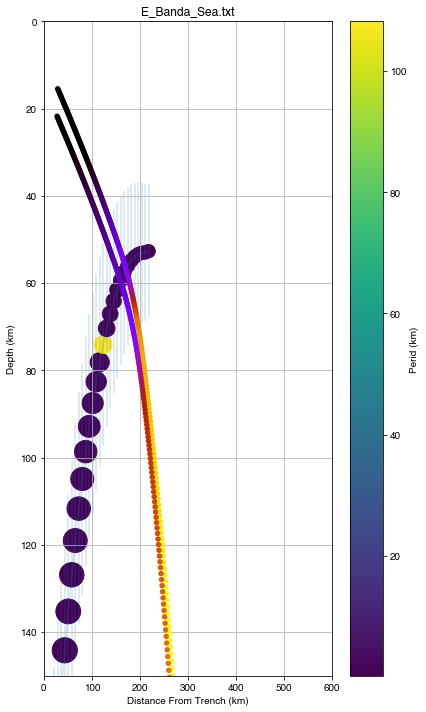

In [42]:
index = 89
SurfaceArray_plot = surface_arrays[closest_indices[index]][0]
MohoArray_plot = surface_arrays[closest_indices[index]][1]

fig, ax = plt.subplots(figsize=(6,10))

scatter = ax.scatter(np.asarray(distance_range[index]),
            tracks[index]['depth'].values,
            c=tracks[index]['peridotte'],
                     s=tracks[index]['temp'], cmap=plt.cm.viridis)
#
#
ax.errorbar(np.asarray(distance_range[index]),
            tracks[index]['depth'].values,
            yerr=tracks[index]['depth_uncertainty'].values,
            alpha=0.2, zorder=1)
#
plot = ax.scatter(SurfaceArray_plot[:,1]-7,SurfaceArray_plot[:,2],s=30,c=SurfaceArray_plot[:,3],\
            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)
ax.scatter(MohoArray_plot[:,1]-7,MohoArray_plot[:,2],s=30,c=MohoArray_plot[:,3],\
            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)

#ax.scatter(np.asarray(cum_distances),
#            np.asarray(interpolated_depths[::-1]+10),
#           c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray(interpolated_depths[::-1]+10), alpha=0.5, c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray([i[2]+10 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')



ax.set_xlabel('Distance From Trench (km)')
ax.set_ylabel('Depth (km)')
ax.set_xlim([0,600])
ax.set_ylim([0,150])
ax.invert_yaxis()
ax.set_title(files[closest_indices[index]])

#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#legend2 = ax.legend(handles, labels, loc="upper right", title="Temperature")


cbar = fig.colorbar(scatter)
cbar.set_label('Perid (km)')
fig.tight_layout()
ax.grid()

#[left, bottom, width, height]


In [ ]:
perid = []
for ind, i in enumerate(relevant_tracks):
    #print(i['peridotte'].values[0])
    plt.scatter(i['lon'], i['lat'], c=i['sum_perid'])
    perid.append(i['sum_perid'])
plt.colorbar()

In [ ]:
water_react = perid_density_kg_km3 * np.sum(total_peridotite)

In [ ]:
H2 = water_react * 10e-2

In [ ]:
H2

now we are just going to plot a few maps to show the context of what we are seeing

In [ ]:
#set directories
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Gernon_shallow_ridges/'
datadir = '/Users/andrew/Documents/Data/'
raster_dir = '/Users/andrew/Documents/Data/Chapman_arc_flare_up_DATA/thickness_grids/'

#model files
rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COB_file = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
isochrons = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)
COBs = pygplates.FeatureCollection(COB_file)
polygons = []
for feature in COBs:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)
COBs=polygons

In [ ]:
    #left rotation
    lat_lon_array = reconstructed_line_left.get_points().to_lat_lon_array()
    lats = lat_lon_array[:,0]
    lons = lat_lon_array[:,1]
    
    line = LineString(zip(lons,lats))
    ax.add_geometries([line], crs=data_crs, color='blue', lw=2)

for n in range(len(reconstructed_coastlines)):
    #print(n)
    # pull out lat/lon vertices
    lat_lon_array = reconstructed_coastlines[n].get_reconstructed_geometry().to_lat_lon_array()
    lats = lat_lon_array[:,0]
    lons = lat_lon_array[:,1]

    # polygons need to be drawn counter clockwise to be drawn properly if they cross the dateline
    if reconstructed_coastlines[n].get_reconstructed_geometry().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
        lats = np.flip(lats)
        lons = np.flip(lons)

    # create the polygon and add it to the axis note that ccrs.Geodetic() must be used to make sure that polygons that cross the dateline are drawn properly
    poly = Polygon(zip(lons,lats))

    #some polygons are very small and don't close properly, so this line just skips those area is in squared degree units (apparently)
    if poly.area < 5e-4:
        continue
        
    ax.add_geometries([poly], crs=data_crs, fc='none', alpha=0.5)

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 

In [ ]:
#globe plotting

times = np.arange(0,1,1)
for time in times:
    raster_file = '%speridotite_thickness_post_serpentinisation%s_Ma.nc' % (raster_dir, time)
    #raster_file = '%sserpentinite_thickness_%s_Ma.nc' % (raster_dir, time)
    peridotite_grid = xr.open_dataset('%s' % raster_file)
    #plate data

    #topology_features = pygplates.FeatureCollection(input_topology_filename)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                           subplot_kw={'projection': ccrs.Orthographic(central_longitude=np.mean(lon),
                                                                       central_latitude=np.mean(lat))})
    data_crs = ccrs.Geodetic()
    poly_data_crs = ccrs.PlateCarree()
    date_line_wrapper = pygplates.DateLineWrapper(0)

    reconstructed_polygons = []
    reconstructed_isochrons = []
    reconstructed_COBs = []

    # Alternative method using 'partition_geometry'
    resolved_topologies = []
    shared_boundary_sections = []

    pygplates.resolve_topologies(input_topology_filename, rotation_model,
                                 resolved_topologies, int(time), shared_boundary_sections)
    #deterministic output
    shared_boundary_sections = sorted(shared_boundary_sections, key=lambda section : section.get_feature().get_feature_id().get_string())


    pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
    pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))
    pygplates.reconstruct(isochrons,rotation_model, reconstructed_isochrons, int(time))

    ax.plot([lon[0], lon[-1]],
            [lat[0], lat[-1]], transform=poly_data_crs, c='k',lw=5,zorder=3)

    for polygon in reconstructed_polygons:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)

    for polygon in reconstructed_COBs:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
            ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='grey', alpha=0.5,
                    linewidth=1 ,zorder=0, transform=poly_data_crs)

    for shared_boundary_section in shared_boundary_sections:
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)                
        else:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                            linewidth=1, alpha=0.5, zorder=1, transform=data_crs)


    plot = ax.imshow(peridotite_grid['peridotite_thickness_post_serpentinisation'],
                     origin='lower', transform=poly_data_crs, zorder=2)
    fig.colorbar(plot)
    #cbar.set_title('Peridotite (km)')
    ax.set_global()
    #ax.set_extent([120, 180, 20, 60])

In [ ]:
plt.figure(figsize=(6,10))
plt.scatter(np.asarray(cum_distances),
            np.asarray(interpolated_depths[::-1]) *-1,
           c=np.asarray(interpolated_variables))
plt.plot(np.asarray(cum_distances),
         np.asarray(interpolated_depths[::-1]) *-1, alpha=0.5, c='k')
plt.plot(np.asarray(cum_distances),
         np.asarray([i[2]*-1 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')
plt.colorbar(label='cumaltive peridotite thickness (km)')
#plt.gca().set_xlim([0, 400])
#plt.gca().set_ylim([-200,0])
plt.xlabel('Distance from trench (km)')
plt.ylabel('Depth (km)')
plt.grid()